<a href="https://colab.research.google.com/github/AlvaroSanzz/Classification-of-self-perception-based-on-from-signals-from-wearable-sensors/blob/main/APSensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import xlrd
from torch.utils.data import Dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#Antes de nada, si tenemos GPU la utilizamos
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [ ]:
from shutil import copyfile
from google.colab import drive
import os, sys
drive.mount('/content/drive/')

Mounted at /content/drive/


# Superprocesado

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import StandardScaler
import os
import glob

def process_excel(df):

    # Crear una lista de palabras clave a buscar en los nombres de las columnas
    palabras_clave = ["position", "acceleration", "velocity", "time"]

    # Encontrar las columnas que contienen alguna de las palabras clave en su nombre
    columnas_a_eliminar = []
    contador = 0
    for columna in df.columns:
        if any(palabra in columna.lower() for palabra in palabras_clave):
            columnas_a_eliminar.append(columna)

    # Eliminar las columnas encontradas
    df = df.drop(columns=columnas_a_eliminar)

    # Iterar sobre las filas del DataFrame en orden inverso para ajustar etiquetas
    ultimo_valor_no_cero = 0
    for indice, fila in df[::-1].iterrows():
        if fila['Label'] != 0:
            ultimo_valor_no_cero = fila['Label']
        else:
            df.at[indice, 'Label'] = ultimo_valor_no_cero

    # Eliminar filas después del último valor no cero en 'Label'
    ultimo_valor_no_cero = df.loc[df['Label'] != 0, 'Label'].iloc[-1]
    indice_ultimo_no_cero = df.loc[df['Label'] == ultimo_valor_no_cero].index[-1]
    df = df.iloc[:indice_ultimo_no_cero + 1]

    # Estandarizar columnas
    df = estandarizar_columnas(df)

    # Crear ventanas
    win_size = 300
    stp = 150
    ventanas = sliding_window_np(df, win_size, stp)

    return ventanas

def estandarizar_columnas(df):
    columnas_excluidas = ['Label']
    columnas_estandarizar = [col for col in df.columns if col not in columnas_excluidas]
    scaler = StandardScaler()
    df[columnas_estandarizar] = scaler.fit_transform(df[columnas_estandarizar])
    return df

def sliding_window_np(df, window_size, step):
    num_windows = (df.shape[0] - window_size) // step + 1
    windows = []
    for i in range(num_windows):
        start = i * step
        end = start + window_size
        window = df.iloc[start:end, :]  # Asegurarse de que la ventana tenga exactamente 'window_size' filas
        if window['Label'].nunique() == 1:
            windows.append(window)
    return windows

def one_hot_encode(labels, num_classes):
    one_hot_labels = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        one_hot_labels[i, label - 1] = 1
    return one_hot_labels

def windows_to_tensors(windows, num_classes):
    tensors = []
    for window in windows:
        features = window.iloc[:, :-1].values
        labels = window.iloc[0, -1]
        labels_one_hot = one_hot_encode([labels], num_classes)[0]
        features_tensor = torch.tensor(features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels_one_hot, dtype=torch.float32)
        tensors.append((features_tensor, labels_tensor))
    return tensors


# Clase para añadir ruido gaussiano
class GaussianNoiseTransform:
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

# Clase de dataset personalizada
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        if self.transform:
            x = self.transform(x)
        return x, y



In [ ]:
all_windows = []
num_classes = 7

path = '/content/drive/My Drive/TFG/RokokoFiles/'

# Buscar todos los archivos CSV en el directorio actual
csv_files = glob.glob(path + '*.csv')

print(csv_files)

# Leer cada archivo CSV y almacenarlos en DataFrames separados

for file in csv_files:
  df = pd.read_csv(file)

  # for file_path in file_paths:
  ventanas = process_excel(df)
  tensor_data = windows_to_tensors(ventanas, num_classes)
  all_windows.extend(tensor_data)

print("EL numero de ventanas es: ", len(all_windows))
print("EL numero de ventanas es: ", len(ventanas))
print("El numero de filas y columnas de cada ventana es: ",ventanas[0].shape)


# Dividir los datos combinados en conjuntos de entrenamiento y prueba
generator = torch.Generator().manual_seed(42)
train_val_size = int(0.8 * len(all_windows))  # Supongamos que queremos el 80% para entrenamiento y validación combinados
test_val_size = len(all_windows) - train_val_size

trainset, testset = random_split(all_windows, [train_val_size, test_val_size], generator=generator)


# Añadir ruido gaussiano solo al conjunto de entrenamiento
gaussian_transform = GaussianNoiseTransform(mean=0.0, std=0.1)
trainset = CustomDataset(trainset, transform=gaussian_transform)






['/content/drive/My Drive/TFG/RokokoFiles/[p185] control-1 Rokoko.csv', '/content/drive/My Drive/TFG/RokokoFiles/[p185] high-1 Rokoko.csv', '/content/drive/My Drive/TFG/RokokoFiles/[p185] high-2 Rokoko.csv', '/content/drive/My Drive/TFG/RokokoFiles/[p185] low-1 Rokoko.csv', '/content/drive/My Drive/TFG/RokokoFiles/[p186] control-1 Rokoko.csv', '/content/drive/My Drive/TFG/RokokoFiles/[p186] control-2 Rokoko.csv', '/content/drive/My Drive/TFG/RokokoFiles/[p186] high-2 Rokoko.csv', '/content/drive/My Drive/TFG/RokokoFiles/[p186] high-1 Rokoko.csv', '/content/drive/My Drive/TFG/RokokoFiles/[p186] low-2 Rokoko.csv', '/content/drive/My Drive/TFG/RokokoFiles/[p188] control-2 Rokoko.csv', '/content/drive/My Drive/TFG/RokokoFiles/[p188] control-1 Rokoko.csv', '/content/drive/My Drive/TFG/RokokoFiles/[p188] high-2 Rokoko.csv', '/content/drive/My Drive/TFG/RokokoFiles/[p188] high-1 Rokoko.csv', '/content/drive/My Drive/TFG/RokokoFiles/[p188] low-1 Rokoko.csv', '/content/drive/My Drive/TFG/Rokoko

In [ ]:
class CustomDataLoader_4D(DataLoader):
    def __init__(self, dataset, batch_size, shuffle, add_channel_dim=True):
        super().__init__(dataset, batch_size, shuffle)
        self.add_channel_dim = add_channel_dim

    def __iter__(self):
        for batch in super().__iter__():
            if self.add_channel_dim:
                batch = self.add_channel_dimension(batch)
            yield batch

    def add_channel_dimension(self, batch):
        data, labels = batch
        data = data.unsqueeze(1)  # Agregar una dimensión de canal
        return data, labels

batch_size = 16
trainloader = CustomDataLoader_4D(trainset, batch_size, shuffle=True)
testloader = CustomDataLoader_4D(testset, batch_size, shuffle=False)

# Verificar la forma del primer lote de datos
for batch_data, batch_labels in trainloader:
    print("Dimensiones del lote de datos:", batch_data.shape)
    print("Dimensiones del lote de etiquetas:", batch_labels.shape)
    break  # Detener después de imprimir el primer lote


Dimensiones del lote de datos: torch.Size([16, 1, 300, 51])
Dimensiones del lote de etiquetas: torch.Size([16, 7])


In [ ]:
print("Tamaño del conjunto de entrenamiento:", len(trainset))
print("Tamaño del conjunto de test:", len(testset))

Tamaño del conjunto de entrenamiento: 9250
Tamaño del conjunto de test: 2313


# Constucción de la red

Primero definiremos las capas

In [ ]:
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()

      # Bloque #1
      self.conv1 = nn.Conv2d(1, 4, 3, padding=1) #poner padding 1
      self.bn1 = nn.BatchNorm2d(4)
      self.conv2 = nn.Conv2d(4, 8, 3, padding=1)
      self.bn2 = nn.BatchNorm2d(8)

      # Bloque #2
      self.conv3 = nn.Conv2d(8, 16, 3, padding=1)
      self.bn3 = nn.BatchNorm2d(16)
      self.conv4 = nn.Conv2d(16, 32, 3, padding=1)
      self.bn4 = nn.BatchNorm2d(32)

      # Bloque #3
      self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
      self.bn5 = nn.BatchNorm2d(64)
      self.conv6 = nn.Conv2d(64, 128, 3, padding=1)
      self.bn6 = nn.BatchNorm2d(128)

      # Bloque #4
      self.conv7 = nn.Conv2d(128, 256, 3, padding=1)
      self.bn7 = nn.BatchNorm2d(256)
      self.conv8 = nn.Conv2d(256, 512, 3, padding=1)
      self.bn8 = nn.BatchNorm2d(512)

      self.pool = nn.MaxPool2d(3, stride=(2, 1), padding=1)

      self.avgpool = nn.AdaptiveAvgPool2d((19, 1))

      self.conv1x1 = nn.Conv2d(19, 1, 1)

      self.fc1 = nn.Linear(512, 128)
      self.fc2 = nn.Linear(128, 256)
      self.fc3 = nn.Linear(256, 7)

      self.bn1d1 = nn.BatchNorm1d(128)
      self.bn1d2 = nn.BatchNorm1d(256)

      self.dropout1 = nn.Dropout(p=0.5)
      self.dropout2 = nn.Dropout(p=0.5)

  def forward(self, x):

    x = F.relu(self.bn1(self.conv1(x)))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))

    x = F.relu(self.bn3(self.conv3(x)))
    x = self.pool(F.relu(self.bn4(self.conv4(x))))

    x = F.relu(self.bn5(self.conv5(x)))
    x = self.pool(F.relu(self.bn6(self.conv6(x))))

    x = F.relu(self.bn7(self.conv7(x)))
    x = self.pool(F.relu(self.bn8(self.conv8(x))))

    x = self.avgpool(x)

    x = x.permute(0, 2, 3, 1)

    x = self.conv1x1(x)

    x = x.flatten(start_dim=1)

    x = F.relu(self.bn1d1(self.fc1(x)))
    # x = self.dropout1(x)
    x = F.relu(self.bn1d2(self.fc2(x)))
    # x = self.dropout2(x)
    x = self.fc3(x)

    return x

In [ ]:
import random
import numpy.random as npr

#We fix seeds for reproducibility
random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.benchmark = True

net = Net() #Invocamos el constructor de la red (método init())
net.to(device) #Pasamos la red al device que estemos usando (gpu)

Net(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c

Testeo para comprobar la dimension de nuestros datos al entrar al salir de la red

# Entrenamiento

In [ ]:
data=next(iter(trainloader))
inputs = data[0].to(device).float()  # Tomamos la primera imagen y le agregamos una dimensión de lote
labels = data[1].to(device)  # Tomamos la primera etiqueta y le agregamos una dimensión de lote

x = inputs.to(device)
print(x.shape)

print("Forma de la imagen:", inputs.shape)
print("Forma de la etiqueta:", labels.shape)
with torch.set_grad_enabled(False):
    outputs = net(inputs)

    print('El tamaño del tensor de salida es {}'.format(outputs.shape))

torch.Size([16, 1, 300, 51])
Forma de la imagen: torch.Size([16, 1, 300, 51])
Forma de la etiqueta: torch.Size([16, 7])
El tamaño del tensor de salida es torch.Size([16, 7])


## Entrenamiento

In [ ]:
def train_loop(trainDataloader, model, criterion, optimizer):
    size = len(trainDataloader.dataset)
    epoch_loss = 0.0  # Inicializar la pérdida de la época
    epoch_correct = 0.0

    for inputs, labels in trainDataloader:  # Iterar sobre el dataloader
      inputs = inputs.to(device).float()  # Mover las imágenes al dispositivo y convertirlas a flotantes
      labels = labels.to(device)  # Mover las etiquetas al dispositivo

      y_pred = model(inputs)  # Realizar predicciones
      loss = criterion(y_pred, labels)  # Calcular la pérdida

      optimizer.zero_grad()  # Reiniciar los gradientes
      loss.backward()  # Realizar la retropropagación
      optimizer.step()  # Actualizar los parámetros

      epoch_loss += loss.item()  # Acumular la pérdida de la muestra actual en la pérdida de la época
      epoch_correct += torch.sum( torch.argmax(y_pred, axis=1) == torch.argmax(labels, axis=1)).item()

    epoch_loss /= len(trainloader)  # Calcular el promedio de la pérdida de la época
    epoch_correct /= size
    print(f"Train Error:\n Accuracy: {(100 * epoch_correct):>0.1f}%, Perdida train: {epoch_loss:>5f}\n")
    return epoch_loss, epoch_correct

def validation_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_correct = 0
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            indicemax = torch.argmax(y_pred, axis=1)
            predicted_onehot = torch.zeros_like(y_pred)
            # predicted_onehot[indicemax] = 1
            predicted_labels = torch.argmax(y_pred, axis=1)  # Obtener la etiqueta predicha unidimensional
            true_labels = torch.argmax(labels, axis=1) #etiqueta verdadera unidimensional
            total_loss += loss.item()
            all_preds.extend(torch.argmax(y_pred, axis=1).cpu().numpy())
            all_labels.extend(torch.argmax(labels, axis=1).cpu().numpy())

            # print("y_pred: ", y_pred)
            # print("labels: ", labels)

            # Calcular el número total de predicciones correctas
            total_correct += torch.sum( torch.argmax(y_pred, axis=1) == torch.argmax(labels, axis=1)).item()
    # Calcular la precisión y la pérdida promedio
    total_correct /= size
    total_loss /= num_batches
    print(f"Validation Error:\n Accuracy: {(100 * total_correct):>0.1f}%, Perdida test: {total_loss:>5f}\n")
    return total_loss, total_correct, all_labels, all_preds

In [ ]:
num_epochs = 150
criterion = torch.nn.CrossEntropyLoss()
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.005)

# Añadir un StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

loss_train, accu_train = np.zeros(num_epochs), np.zeros(num_epochs)
loss_validation, accu_validation = np.zeros(num_epochs), np.zeros(num_epochs)

for epoch in range(num_epochs):
    print(f"Epoca {epoch + 1}/{num_epochs}")
    loss_train[epoch], accu_train[epoch] = train_loop(trainloader, model, criterion, optimizer)
    loss_validation[epoch], accu_validation[epoch], all_labels, all_preds = validation_loop(testloader, model, criterion)

    # Actualizar el learning rate según el scheduler
    scheduler.step()

    print("----------------------------------")

Epoca 1/150
Train Error:
 Accuracy: 22.5%, Perdida train: 1.836292

Validation Error:
 Accuracy: 23.7%, Perdida test: 1.774079

----------------------------------
Epoca 2/150
Train Error:
 Accuracy: 25.8%, Perdida train: 1.770176

Validation Error:
 Accuracy: 24.4%, Perdida test: 1.744148

----------------------------------
Epoca 3/150
Train Error:
 Accuracy: 26.2%, Perdida train: 1.753073

Validation Error:
 Accuracy: 26.5%, Perdida test: 1.738637

----------------------------------
Epoca 4/150
Train Error:
 Accuracy: 30.2%, Perdida train: 1.702615

Validation Error:
 Accuracy: 29.4%, Perdida test: 1.702068

----------------------------------
Epoca 5/150
Train Error:
 Accuracy: 30.6%, Perdida train: 1.690311

Validation Error:
 Accuracy: 29.8%, Perdida test: 1.687393

----------------------------------
Epoca 6/150
Train Error:
 Accuracy: 35.2%, Perdida train: 1.614682

Validation Error:
 Accuracy: 33.2%, Perdida test: 1.618968

----------------------------------
Epoca 7/150
Train Erro

Text(0, 0.5, 'Error')

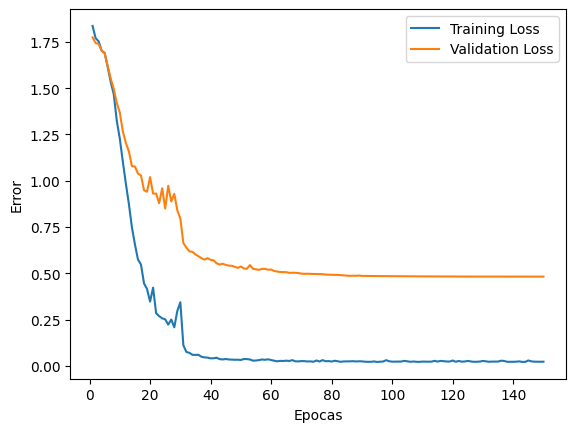

In [ ]:
import matplotlib.pyplot as plt

#Representación de los resultados
lista = list(range(1, len(loss_validation) + 1))
plt.plot(lista, loss_train, lista , loss_validation)
plt.legend(('Training Loss', 'Validation Loss'))

# Añadir etiquetas a los ejes
plt.xlabel('Epocas')
plt.ylabel('Error')



Text(0, 0.5, 'Accuracy')

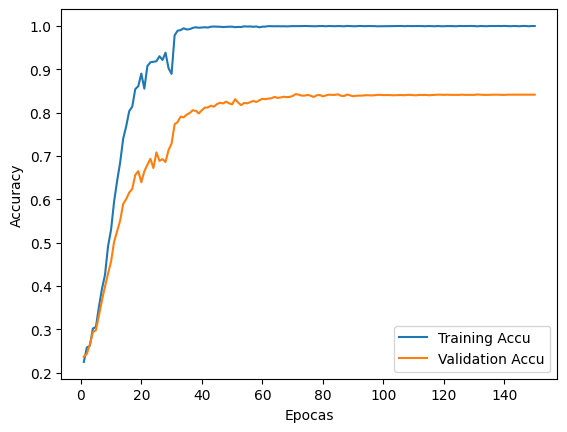

In [ ]:
#Representación de los resultados
lista = list(range(1, len(accu_validation) + 1))
plt.plot(lista, accu_train, lista , accu_validation)
plt.legend(('Training Accu', 'Validation Accu'))

# Añadir etiquetas a los ejes
plt.xlabel('Epocas')
plt.ylabel('Accuracy')

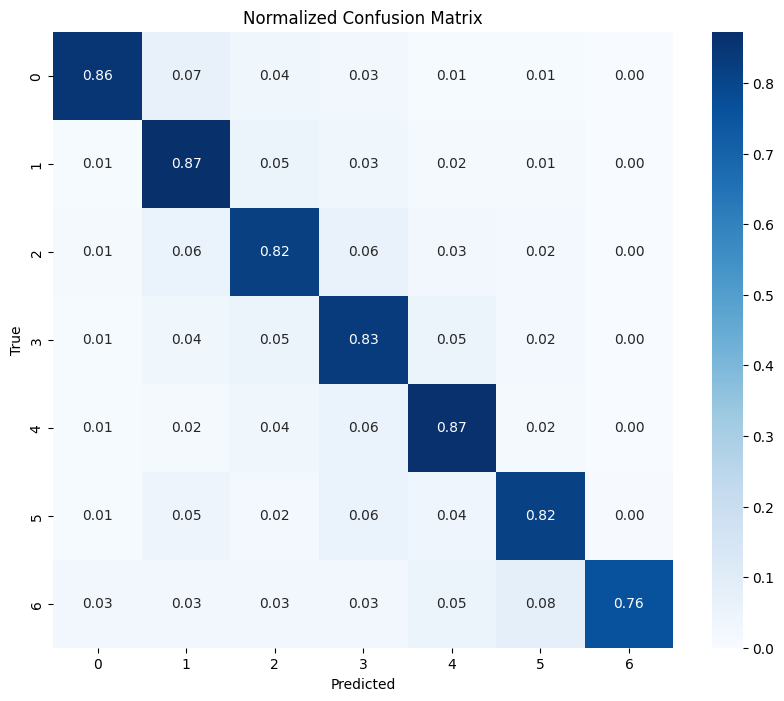

In [ ]:
 # Generar matriz de confusión solo para la última época
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Función para normalizar la matriz de confusión
def normalize_confusion_matrix(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = normalize_confusion_matrix(cm)
classes = [str(i) for i in range(7)]  # Asumiendo 7 clases

# Plot de la matriz de confusión normalizada
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']
print(classification_report(all_labels, all_preds, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.84      0.86      0.85       138
     class 1       0.83      0.87      0.85       440
     class 2       0.86      0.82      0.84       563
     class 3       0.82      0.83      0.83       498
     class 4       0.84      0.87      0.85       378
     class 5       0.85      0.82      0.83       258
     class 6       0.94      0.76      0.84        38

    accuracy                           0.84      2313
   macro avg       0.85      0.83      0.84      2313
weighted avg       0.84      0.84      0.84      2313

